## Install Libraries

In [1]:
import openseespy.opensees as ops
import opsvis as opsv
import math as math
from math import asin, sqrt
import numpy as np
import matplotlib.pyplot as plt

## Unit Definition

In [2]:
# =============================================================================
# Define Units
# =============================================================================

m = 1.0               # Meters
KN = 1.0              # KiloNewtons
N = 0.001*KN
sec = 1.0             # Seconds

mm = 0.001*m          # Milimeters
cm = 0.01*m           # Centimeters 
MPa = 1e3*(KN/m**2)   # Mega Pascal 
GPa = 1e6*(KN/m**2)   # Giga Pascal 

## Build Model - Reinforced Concrete Frame

In [3]:
# Clear memory of past model definitions
ops.wipe()

# Create ModelBuilder (with two-dimensions and 3 DOF/node)
ops.model('Basic', '-ndm', 2, '-ndf', 3)

# Structural frame
numBay = 1
numFloor = 3
bayWidth = 7.35*m
storyH = 3*m
storyHT = storyH*(numFloor)
storyHeights = [storyH]*numFloor # same height for all sotries

In [4]:
def getColumn():
    
    # =============================================================================
    # Materials
    # =============================================================================
    
    # Define concrete material
    f_c_1 = -25 * MPa          # f'c in compression for unconfined concrete
    f_c_2 = -28 * MPa          # f'c in compression for confined concrete
    eps_c = -0.002             # strain at maximum stress in compression 
    eps_u = -0.02              # strain at ultimate stress in compression
    f_y = 420.0 * MPa          # fy for reinforcing steel
    E_s = 210.0 * GPa          # E for reinforcing steel

    rebar = 0.25 * np.pi * (25 * mm) ** 2

    # Uniaxial Kent-Scott-Park concrete material with degraded linear unloading/reloading
    mat_KSP_unconf = {
        'ID': 'Concrete02',
        'matTag': 1,
        'fpc': f_c_1,
        'epsc0': eps_c,
        'fpcu': 0.2 * f_c_1,
        'epsU': eps_u,
        'lamda': 0.1,
        'ft': -0.1 * f_c_1,
        'Ets': (-0.1 * f_c_1) / 0.002
    }

    # Uniaxial Kent-Scott-Park concrete material with degraded linear unloading/reloading...confined
    mat_KSP_conf = {
        'ID': 'Concrete02',
        'matTag': 2,
        'fpc': f_c_2,
        'epsc0': eps_c,
        'fpcu': 0.2 * f_c_2,
        'epsU': eps_u,
        'lamda': 0.1,
        'ft': -0.1 * f_c_2,
        'Ets': (-0.1 * f_c_2) / 0.002
    }

    # Uniaxial Giuffre-Menegotto-Pinto steel with isotropic strain hardening
    mat_GMP = {
        'ID': 'Steel02',
        'matTag': 3,
        'Fy': f_y,
        'E0': E_s,
        'b': 0.005,
        'R0': 20.0,
        'cR1': 0.925,
        'cR2': 0.15
    }

    # Confined & unconfined concrete material 
    ops.uniaxialMaterial(*mat_KSP_unconf.values())
    ops.uniaxialMaterial(*mat_KSP_conf.values())
    
    # For reinforcing steel
    ops.uniaxialMaterial(*mat_GMP.values())

    # =============================================================================
    # Rebar Placing
    # =============================================================================
    
    h = 500 * mm  # height
    w = 500 * mm  # width 
    ct = 50 * mm  # cover thickness
    ar = h * w    # cross-sectional area
    dia = 24 * mm # rebar diameter
    Abar = np.pi * (dia / 2) ** 2  # rebar area
    numBar = 4  # number of rebars top/bottom
    numInt = 2  # number of rebars intermediate layers
    numBarS = int(numInt / 2)  # intermediate per side
    nfCoreY = 10
    nfCoreZ = 10
    nfCoverY = 10
    nfCoverZ = 10

    # Define Rebar vertices
    coverY = h / 2.0
    coverZ = w / 2.0
    coreY = coverY - ct
    coreZ = coverZ - ct
    IntYStart = -coreY + 2 * coreY / (numBarS + 1)  # Bottom (y-axis) coordinate for intermediate bars 
    IntYEnd = coreY - 2 * coreY / (numBarS + 1)  # Top (y-axis) coordinate for intermediate bars

    # =============================================================================
    # Test Sections
    # =============================================================================
    
    # Section('Fiber', secTag)
    ops.section('Fiber', 1)

    # Patch('quad', matTag, numSubdivIJ, numSubdivJK, *crdsI, *crdsJ, *crdsK, *crdsL)
    # Core patch
    ops.patch('quad', 2, nfCoreZ, nfCoreY, -coreY, coreZ, -coreY, -coreZ, coreY, -coreZ, coreY, coreZ)
    
    # Cover patch
    ops.patch('quad', 1, 2, nfCoverY, -coverY, coverZ, -coreY, coreZ, coreY, coreZ, coverY, coverZ)
    ops.patch('quad', 1, 2, nfCoverY, -coreY, -coreZ, -coverY, -coverZ, coverY, -coverZ, coreY, -coreZ)
    ops.patch('quad', 1, nfCoverZ, 2, -coverY, coverZ, -coverY, -coverZ, -coreY, -coreZ, -coreY, coreZ)
    ops.patch('quad', 1, nfCoverZ, 2, coreY, coreZ, coreY, -coreZ, coverY, -coverZ, coverY, coverZ)

    # Define reinforcing layers
    ops.layer('straight', 3, numBarS, Abar, IntYStart, coreZ, IntYEnd, coreZ)  # intermediate skin reinf. +z
    ops.layer('straight', 3, numBarS, Abar, IntYStart, -coreZ, IntYEnd, -coreZ)  # intermediate skin reinf. -z
    ops.layer('straight', 3, numBar, Abar, coreY, coreZ, coreY, -coreZ)  # top layer reinforcement
    ops.layer('straight', 3, numBar, Abar, -coreY, coreZ, -coreY, -coreZ)  # bottom layer reinforcement

    # GeomTransf('Linear', transfTag, *vecxz, '-jntOffset', *dI, *dJ)
    ops.geomTransf('PDelta', 1, [-1, 0, 0])  # column
    ops.geomTransf('Linear', 2, [0, 1, 0])   # beam

    # BeamIntegration('Lobatto', tag, secTag, N)
    ops.beamIntegration('Lobatto', 3, 1, 3)   # column
    ops.beamIntegration('Lobatto', 4, 1, 5)  # beam 

    # =============================================================================
    # Display Section
    # =============================================================================
    
    fiber_sec = [['section', 'Fiber', 1],
                     ['patch', 'quad', 2, nfCoreZ, nfCoreY, -coreY, coreZ, -coreY, -coreZ, coreY, -coreZ, coreY, coreZ],
                     ['patch', 'quad', 1, 2, nfCoverY, -coverY, coverZ, -coreY,   coreZ,   coreY,   coreZ,  coverY, coverZ],
                     ['patch', 'quad', 1, 2, nfCoverY, -coreY, -coreZ,  -coverY, -coverZ,  coverY, -coverZ, coreY,  -coreZ],
                     ['patch', 'quad', 1, nfCoverZ, 2, -coverY, coverZ, -coverY, -coverZ, -coreY,  -coreZ, -coreY,   coreZ],
                     ['patch', 'quad', 1, nfCoverZ, 2,  coreY,  coreZ,   coreY,  -coreZ,   coverY, -coverZ, coverY, coverZ],
                     ['layer', 'straight', 3 ,numBarS ,Abar, IntYStart,  coreZ,  IntYEnd,  coreZ],
                     ['layer', 'straight', 3 ,numBarS ,Abar, IntYStart,  -coreZ,  IntYEnd,  -coreZ],
                     ['layer', 'straight', 3 ,numBar ,Abar,  coreY,  coreZ,  coreY, -coreZ],
                     ['layer', 'straight', 3 ,numBar ,Abar, -coreY,  coreZ, -coreY, -coreZ]
                    ]

    matcolor = ['r', 'lightgrey', 'gold', 'w', 'w', 'w']
    opsv.plot_fiber_section(fiber_sec, matcolor=matcolor)
    plt.axis('equal')
    plt.show()

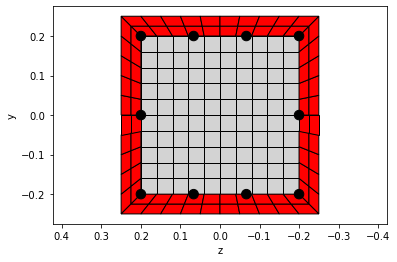

In [5]:
getColumn()

# =============================================================================
# Define Nodes
# =============================================================================

# Create nodes
nodeTag = 1

# Nodetag for Integration Points
yLoc = 0.
for j in range(0, numFloor + 1):

    xLoc = 0.
    for i in range(0, numBay + 1):
        ops.node(nodeTag, xLoc, yLoc)
        xLoc += bayWidth
        nodeTag += 1
    if j < numFloor:
        storyHeight = storyHeights[j]

    yLoc += storyHeight

# Assign Constraints
# (kj) number of row has to match the number of ground fix points
ops.fix(1, 1, 1, 1)
ops.fix(2, 1, 1, 1)

# =============================================================================
# Assign Column and Beam (element tag and material)
# =============================================================================

# Add column elements
eleTag = 1
for j in range(0, numBay + 1):
    end1 = j + 1
    end2 = end1 + numBay + 1
    #secType = beams[j - 1]
    for i in range(0, numFloor):
        # element('forceBeamColumn', eleTag, *eleNodes, transfTag, integrationTag, '-iter', maxIter=10, tol=1e-12)
        ops.element('forceBeamColumn', eleTag, *[end1, end2], 1, 3, '-iter', 10, 1e-12)
        end1 = end2
        end2 += numBay + 1
        eleTag += 1
        
# Add beam elements
# (kj) range starts from 1 = no floor on the ground
for j in range(1, numFloor + 1):
    end1 = (numBay + 1) * j + 1
    end2 = end1 + 1
    #secType = beams[j - 1]
    for i in range(0, numBay):
        # element('forceBeamColumn', eleTag, *eleNodes, transfTag, integrationTag, '-iter', maxIter=10, tol=1e-12)
        ops.element('forceBeamColumn', eleTag, *[end1, end2], 2, 4, '-iter', 10, 1e-12)
        end1 = end2
        end2 = end1 + 1
        eleTag += 1
    
# Rigid floor constraint & masses
# (kj) node that are next to each other, they move together, whereas node that are apart they are assigned a very small number
massX = 100
nodeTagR = 2 #nodeTagR +1
nodeTag = 1 #first floor node
for j in range(1, numFloor + 1):
    for i in range(0, numBay + 1):

        if nodeTag != nodeTagR:
            ops.equalDOF(nodeTagR, nodeTag, 1)
        else:
            ops.mass(nodeTagR, massX, 1.0e-10, 1.0e-10)

        nodeTag += 1

    nodeTagR += numBay + 1

Text(0.5, 1.0, 'Element tag')

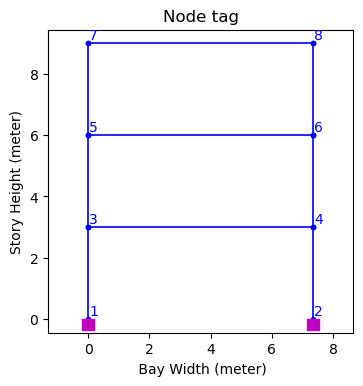

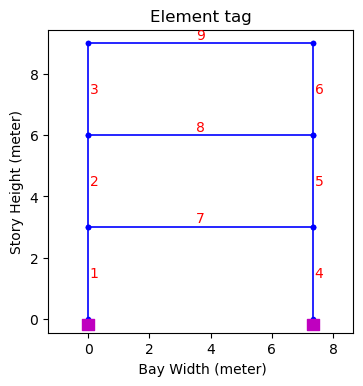

In [ ]:
# =============================================================================
# Display Model Tag
# =============================================================================
# Node tag
opsv.plot_model(1, 0, fig_wi_he=(10,10), gauss_points=(False))
plt.xlabel(' Bay Width (meter)')
plt.ylabel('Story Height (meter)')
plt.title('Node tag')

# Element tag
opsv.plot_model(0, 1, fig_wi_he=(10,10), gauss_points=(False))
plt.xlabel(' Bay Width (meter)')
plt.ylabel('Story Height (meter)')
plt.title('Element tag')

## Linear Static Analysis

In [8]:
import requests
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [9]:
# =============================================================================
# Hazard Analysis
# =============================================================================

def get_spectra_acceleration(x):
    # Define the URL and parameters
    url = 'http://appsrvr.share-eu.org/share/spectra'
    params = {
        'lat': 38.424, # latitude
        'lon': 27.143, # longitude
        'id': 68,
        'imt': 'SA',
        'poe': 0.1, # int 1 (0.5), int 2 (0.39), int 3 (0.1), int 4 (0.05), int 5 (0.02), int 6 (0.01)
        'timespanpoe': 50, # 50 years
        'soiltype': 'rock_vs30_800ms-1',
        'aggregationtype': 'arithmetic',
        'aggregationlevel': 0.5
    }

    # Send a GET request to the URL with the parameters
    response = requests.get(url, params=params)

    # Parse the response text as an XML tree
    root = ET.fromstring(response.text)

    # Extract the spectral periods and accelerations from the XML
    spectra_periods = np.array(root.find('.//{http://openquake.org/xmlns/nrml/0.3}spectraPeriodList').text.split(), dtype=float)
    spectra_accelerations = np.array(root.find('.//{http://openquake.org/xmlns/nrml/0.3}IML').text.split(), dtype=float)

    # Interpolate the spectral accelerations using linear interpolation
    interp_func = interp1d(spectra_periods, spectra_accelerations, kind='linear')

    # Estimate the acceleration value at the input x using the interpolation function
    spectra_acceleration = interp_func(x)

# =============================================================================
# Disply Design Spectrum
# =============================================================================

    # Plot the hazard spectrum curve
    poe_percent = int(params['poe']*100)
    plt.plot(spectra_periods, spectra_accelerations, label=f'{poe_percent}% in 50 years', color='k')
    plt.grid(True, linewidth=0.5)
    plt.xlabel('Spectral Period (sec)')
    plt.ylabel('Spectral Acceleration (g)')
    plt.title('Hazard Spectrum')
    plt.ylim(0, 2)

    # Add vertical dotted line at T = 1.76
    Saa = np.interp(T, spectra_periods, spectra_accelerations)
    plt.axvline(x=T, linestyle='--', color='gray')

    # Add a point at Sa(T) on the curve
    plt.plot(T, Saa, 'o', color='red', markersize=5)

    # Add (x,y) value next to the point on the curve
    plt.text(T, Saa, f'T = {T:.2f}, Sa = {Saa:.2f}', ha='left', va='bottom')
    plt.legend()
    plt.show()

    return spectra_acceleration

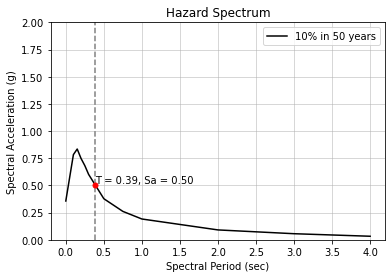

In [10]:
# =============================================================================
# Fundamental period of vibration
# =============================================================================

C_t = 0.075              # 0.035 in inches
T = C_t * storyHT**(3/4) # ATC3-06
Ta = (0.3048 * numFloor / math.sqrt(7350*mm*3.28084))**0.5
Sa = get_spectra_acceleration(T)

In [11]:
# =============================================================================
#  Static Analysis
# =============================================================================

# Parameters for Lateral Load calc
C = 1. #1. # Table 4-8 Moment Frame
w = 730.6 * 9.96402 # unit KN (tons times 9,9), weight per floor
W =  w*numFloor

# Calculate eigenvalues & print results
numEigen = numFloor
eigenValues = ops.eigen(numEigen)
PI = 2 * asin(1.0)

# Apply Load Pattern
ops.timeSeries('Linear', 1)
ops.pattern('Plain', 1, 1)

# Seismic Base Shear
omega = 2**(1/2)
R = 5
Vyl = omega * Sa * W / R
S = Sa * T * W / Vyl
V = Sa / R * W # in KN

# Load Distribution
tagdisp = []
storyforce = []
sumwihi = 0
k = 1 + (T - 0.5) * (2 - 1) / (2.5 - 0.5)

for i in range (1,numFloor+1):
    wi = w
    hi = storyH * i
    sumwihi += wi *(hi**k)
for floorN in range (1, numFloor + 1):
    wx = w                       # lumped weight at floor level x
    hx = storyH * floorN         # height above base to the floor level x
    Cvx = wx * (hx**k) / sumwihi # vertical distribution factor
    Fx = Cvx * V                 # Pseudo Force at x
    storyforce.append(Fx)
    nodex = 1+floorN*(numBay+1)
    tagdisp.append(nodex)
    print(f"{floorN:.0f}", f"{Cvx:.3f}", f"{Fx:.0f}")
for i in range(len(tagdisp)):
    ops.load(tagdisp[i], storyforce[i], 0., 0.)

ops.integrator('LoadControl', 1)
ops.algorithm('Linear')
ops.analysis('Static')
ops.analyze(1)

1 0.174 381
2 0.335 733
3 0.491 1075


0

Text(0, 0.5, 'Story Height (meter)')

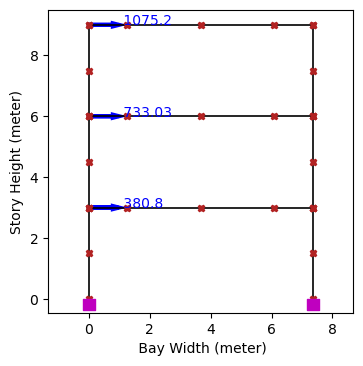

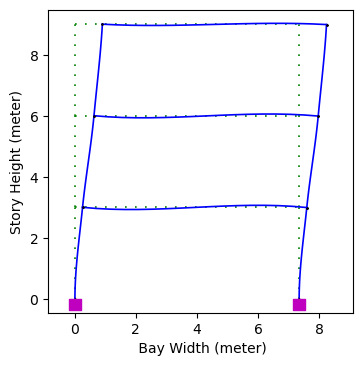

In [ ]:
# =============================================================================
# Display Model Tag
# =============================================================================

# Plot lateral load
opsv.plot_loads_2d(fig_wi_he=(10,10))
plt.xlabel(' Bay Width (meter)')
plt.ylabel('Story Height (meter)')

# Plot deformation
opsv.plot_defo(fig_wi_he=(10,10))
plt.xlabel(' Bay Width (meter)')
plt.ylabel('Story Height (meter)')

In [12]:
# =============================================================================
#  Calculate Interstory Drift
# =============================================================================

# Calculate displacement
dispout = []
for i in range(len(tagdisp)):
    # nodeDisp(nodeTag, dof=-1)
    output = ops.nodeDisp(tagdisp[i],1)
    dispout.append(output)


# Calculate story drift
driftratio = []
dispp = np.insert(dispout,0,0) #to get story drift for the first floor
for i in range(len(dispp)-1):
    delta_i = dispp[i+1]-dispp[i]
    ratio = delta_i/storyH
    driftratio.append(ratio)
    
# Inelastic behavior higher mode effects
correction = []
for i in range (1,numFloor+1):
    h = storyH* (i+1)
    b = h/storyHT
    ln_Hi = 0.67 - 0.044*T - 0.098*S - 1.37*b + 1.71*(b**2) - 0.57*(b**3)
    Hi = math.exp(ln_Hi)
    correction.append(Hi)
Mdriftratio = np.array(driftratio) * np.array(correction)
flip = Mdriftratio[::-1] #input PACT

# Interstory drift ratio (%)
floornum = np.arange(1, numFloor+1)
storydrift = np.array(driftratio)*100 # unit percentage

# Interstory drift ratio (-)
Mdriftratio = np.concatenate(([0.0], Mdriftratio))
floornum = np.concatenate(([0.0], floornum)).astype(int)

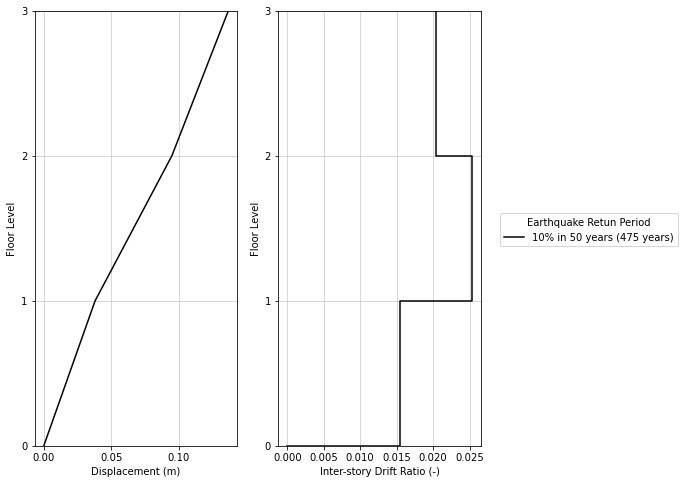

In [13]:
# =============================================================================
# Display Story Drift
# =============================================================================

lab = '10% in 50 years (475 years)'
fig, (bx, ax) = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))
# Plot displacement
#fig, bx = plt.subplots(figsize=(4,8))
bx.plot(dispp, [2*y for y in floornum], label=lab, color='k')
bx.set_xlabel('Displacement (m)')
bx.set_ylabel('Floor Level')
bx.set_ylim(0, 2*max(floornum))
bx.set_yticks([2*y for y in floornum])
bx.set_yticklabels(floornum)
bx.grid(True, linewidth=0.5)

# Plot drift ratio
#fig, ax = plt.subplots(figsize=(4,8))
ax.step(Mdriftratio, [2*y for y in floornum],where='post', label=lab, color='k')
#ax.set_xlim(0, 1.1*max(driftratio))
ax.set_ylim(0, 2*max(floornum))
ax.set_xlabel('Inter-story Drift Ratio (-)')
ax.set_ylabel('Floor Level')
ax.set_yticks([2*y for y in floornum])
ax.set_yticklabels(floornum)
ax.grid(True, linewidth=0.5)
#ax.legend(labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=1)

# Add legend
handles, labels = ax.get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1)
legend.set_title('Earthquake Retun Period')